In [1]:
import numpy as np
import h5py
from pathlib import Path
from extra_geom import AGIPD_1MGeometry
from cxiapi import litPixelsAnalyzer, cxiData, calibrateModule
from cxiapi.hitAnalyzer import hitAnalyzer
import matplotlib.pyplot as plt
from p_tqdm import p_umap, p_map
from functools import partial
import multiprocessing as mp

In [2]:
# Experiment run number.
run = 364
# Hitfinding on which module.
module = 15
# Number of CPU processes to use, '0' means using all.
nproc = 0
# The folder of cxi files
cxi_folder = '/gpfs/exfel/u/scratch/SPB/202130/p900201/spi-comission/vds/'
# Cheetah files folder for calibration
calib_folder = '/gpfs/exfel/exp/SPB/202130/p900201/usr/Software/calib/r0361-r0362-r0363/'
# Geometry file for the detector
geom_file = '/gpfs/exfel/exp/SPB/202130/p900201/usr/Software/geom/agipd_2696_v5.geom'

In [3]:
cxi_path = Path(cxi_folder, f'r{run:04}.cxi')
fn = str(cxi_path)

cxi = cxiData(fn, verbose=1, debug=0)
pulse = np.arange(0, 352)
base_pulse_filter = np.ones(600, dtype="bool")
base_pulse_filter[len(pulse):] = False
base_pulse_filter[0] = False
base_pulse_filter[18::32] = False
base_pulse_filter[29::32] = False
good_cells = pulse[base_pulse_filter[:len(pulse)]]
cxi.setGoodCells(good_cells)
cxi.setCalib(calib_folder)
cxi.setGainMode(0)

VDS file contains 573056 shots
Module 0 contains 352 cells
16 calibration files found


In [4]:
cxi.data.shape

(573056, 16, 2, 512, 128)

In [5]:
cxi.good_frames.shape

(535612,)

In [6]:
hits_analyzer = hitAnalyzer(cxi_data = cxi, verbose=1)
hits_analyzer.setAdu_per_photon(45)

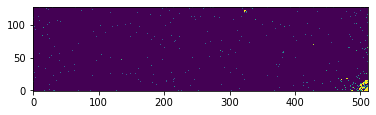

In [7]:
hits_analyzer.plotModule(300,15,is_transpose = True)

Text(0.5, 1.0, 'After mask')

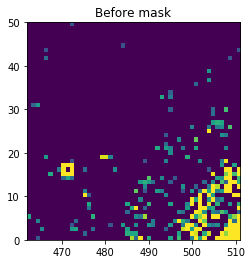

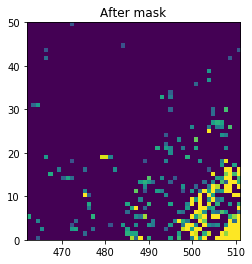

In [8]:
# ROI
ROI = (slice(512-50,None), slice(None,51))
hits_analyzer.setROI(ROI)
# Mask
mask = np.ones((512,128))
hits_analyzer.setModuleMasks(15,mask)
hits_analyzer.plotROI(300,15,is_transpose=True)
plt.title('Before mask')

mask[470:473,15:18] = 0
hits_analyzer.setModuleMasks(15,mask)
hits_analyzer.plotROI(300,15,is_transpose=True)
plt.title('After mask')

In [9]:
# good_frames = cxi.good_frames
# hits_analyzer.getHits(good_frames, 15, 5)

In [10]:
data = cxi.data
good_frames = cxi.good_frames
data = cxi.data
cell_ids = cxi.cellIDs
module_index = 15
intens_thresh = 5
module_mask = hits_analyzer.module_masks[str(module_index)]
ROI = hits_analyzer.ROI
adu_per_photon = hits_analyzer.adu_per_photon

In [11]:
def filter_snapshots_mp(data_set, threshold=5.):
#     with mp.Pool(mp.cpu_count()) as pool:
#         results = pool.starmap_async(check_snapshot, [(n,) for n in data_set]).get()
    #results = results.get()
    results = p_umap(check_snapshot, data_set)
    return results

In [12]:
# %%time 
# intens_thresh = 5
# results = p_umap(check_snapshot, cxi.good_frames[:1000])
# result = filter_snapshots_mp(cxi.good_frames[:1000], 5.)

In [13]:
def getHits(idx_range: list) -> list:
    # Get the index of the hits
    with mp.Pool(21) as pool:
#     with mp.Pool(mp.cpu_count()) as pool:

#         results = pool.starmap_async(
#             check_snapshot, [(snap_idx, module_index) for snap_idx in idx_range]).get()
        results = p_umap(partial(check_snapshot,module_index=15), idx_range)
    hits_indices = list(filter((None).__ne__, results))
    return  hits_indices

def getCalibData(cxi_data, snap_idx, module_index):
    n = snap_idx
    data = cxi_data.data
    cell_ids = cxi_data.cellIDs

    calib_data = calibrateModule(data[n, module_index, 0, :, :],
                                    data[n, module_index,
                                        1, :, :], module_index,
                                    cell_ids[n, 0], cxi_data.calib)
    return calib_data

def check_snapshot(snap_idx, module_index):
    calib_data = getCalibData(cxi, snap_idx, module_index)
    roi_data = calib_data[ROI]
    nphotons = roi_data / adu_per_photon
    nphotons[nphotons < 0.5] = 0
    if intens_thresh < np.log(nphotons.sum()):
        return snap_idx

In [ ]:
idx_range = cxi.good_frames
module_index = 15
intens_thresh = 5
module_mask = hits_analyzer.module_masks[str(module_index)]
ROI = hits_analyzer.ROI
adu_per_photon = hits_analyzer.adu_per_photon

# hits_indices = getHits(idx_range, module_index,
#             intens_thresh, module_mask, ROI, adu_per_photon)
hits_indices = getHits(idx_range)

Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Process ForkPoolWorker-19:
Process ForkPoolWorker-6:
Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-4:
Process ForkPoolWorker-9:
Process ForkPoolWorker-15:
Process ForkPoolWorker-17:
Process ForkPoolWorker-20:
Process ForkPoolWorker-7:
Process ForkPoolWorker-14:
Process ForkPoolWorker-16:
Process ForkPoolWorker-18:
Process ForkPoolWorker-12:
Process ForkPoolWorker-1:
Process ForkPoolWorker-10:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/gpfs/exfel/sw/software/xfel_anaconda3/1.1/lib/py